**Imports**

In [ ]:
#Importing all nessary libraies

# Importing the Google Colab drive module to access dataset
from google.colab import drive
drive.mount('/content/drive')

# Importing matplotlib for plotting
import matplotlib.pyplot as plt
import numpy as np

# Installing the pyrsgis library, useful for remote sensing data analysis
!pip install pyrsgis
# Importing the raster module from pyrsgis for raster data operations
from pyrsgis import raster

# Installing the rasterio for handling raster data
!pip install rasterio
import rasterio

# Installing the TensorFlow
!pip install tensorflow
import tensorflow as tf

# Importing scikit-learn and other imports for training data preprocessing
import sklearn
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import random
from scipy import interp
from itertools import cycle

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.6 MB/s eta 0:00:00


**Data preprocesssing**

In [ ]:
# Defining file names
featuresFile = r'/content/drive/MyDrive/Sistan_Landsat8.tif'
labelsFile = r'/content/drive/MyDrive/Sistan_Landsat8_Training.tif'

# Read and normalize the feature raster
with rasterio.open(featuresFile) as src:
    Array_Features = src.read().transpose(1, 2, 0)  # Transpose to (height, width, bands)
    scaler = MinMaxScaler()
    Array_Features = scaler.fit_transform(Array_Features.reshape(-1, Array_Features.shape[2]))
    Array_Features =  Array_Features.reshape(src.height, src.width, -1)

# Read the label raster
with rasterio.open(labelsFile) as src:
    Array_Labels = src.read(1)  # Assuming labels are in the first band
    Array_Labels[Array_Labels == 255] = 0
    classes = np.unique(Array_Labels)
    length = len(classes)

# Extract patches for both features and labels
patch_size = (7, 7)
features_patches = extract_patches_2d(Array_Features, patch_size)
labels_patches = extract_patches_2d(Array_Labels, patch_size)

# For labels use mode to decide the label of a patch
labels = np.array([np.bincount(patch.ravel()).argmax() for patch in labels_patches])

# Ensure labels are matched to features by reshaping
assert features_patches.shape[0] == labels.shape[0], "Features and labels must have the same number of patches."

# Filter out unwanted labels (if 0 is unwanted)
valid_indices = labels != 0
filtered_features = features_patches[valid_indices]
filtered_labels = labels[valid_indices]

# Split the data into trainig and testing data
train_x, test_x, train_y, test_y = train_test_split(filtered_features, filtered_labels, train_size=0.7, stratify=filtered_labels)


**VGG16 after editing architecture**

In [ ]:
# Assuming train_x is your training data
train_x_shape = train_x.shape

# Input layer
inputs = tf.keras.Input(shape=train_x_shape[1:])  # Use train_x shape directly

# Block 1
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)

# Flatten
x = tf.keras.layers.Flatten(name='flatten')(x)

# Fully connected layers
x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)

# Output layer
outputs = tf.keras.layers.Dense(length, activation='softmax', name='predictions')(x)

# Create model
vgg16_model = tf.keras.Model(inputs, outputs)

# Print model summary
print(vgg16_model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 6)]         0         
                                                                 
 block1_conv1 (Conv2D)       (None, 7, 7, 64)          3520      
                                                                 
 block1_conv2 (Conv2D)       (None, 7, 7, 64)          36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 3, 3, 64)          0         
                                                                 
 block2_conv1 (Conv2D)       (None, 3, 3, 128)         73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 3, 3, 128)         147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 1, 1, 128)         0     

**Running the model**

In [ ]:
# Compile the VGG16 model
vgg16_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train the VGG16 model
history = vgg16_model.fit(train_x, train_y, epochs=95)

print("")

# Evaluateing the model for the test data
test_loss, test_acc = vgg16_model.evaluate(test_x, test_y)
print("Test Accuracy:", test_acc)

Epoch 1/95
63/63 [==============================] - 8s 24ms/step - loss: 1.6076 - accuracy: 0.3330
Epoch 2/95
63/63 [==============================] - 1s 14ms/step - loss: 1.3962 - accuracy: 0.4529
Epoch 3/95
63/63 [==============================] - 1s 16ms/step - loss: 1.0660 - accuracy: 0.6489
Epoch 4/95
63/63 [==============================] - 1s 15ms/step - loss: 1.0267 - accuracy: 0.6881
Epoch 5/95
63/63 [==============================] - 1s 12ms/step - loss: 0.9445 - accuracy: 0.7252
Epoch 6/95
63/63 [==============================] - 1s 13ms/step - loss: 0.7705 - accuracy: 0.7733
Epoch 7/95
63/63 [==============================] - 1s 14ms/step - loss: 0.7120 - accuracy: 0.8049
Epoch 8/95
63/63 [==============================] - 1s 13ms/step - loss: 0.6491 - accuracy: 0.8200
Epoch 9/95
63/63 [==============================] - 1s 11ms/step - loss: 0.6613 - accuracy: 0.8089
Epoch 10/95
63/63 [==============================] - 1s 12ms/step - loss: 0.6286 - accuracy: 0.8104
Epoch 11/

**Check overvfitting**

In [ ]:
# Evaluate on training data
train_predictions = vgg16_model.predict(train_x)
train_predictions = np.argmax(train_predictions, axis=1)
train_accuracy = accuracy_score(train_y, train_predictions)
print(f"Training Accuracy: {train_accuracy}")

# Evaluate on testing data
test_predictions = vgg16_model.predict(test_x)
test_predictions = np.argmax(test_predictions, axis=1)
test_accuracy = accuracy_score(test_y, test_predictions)
print(f"Testing Accuracy: {test_accuracy}")

# Check for overfitting
if train_accuracy > test_accuracy:
    difference = train_accuracy - test_accuracy
    print(f"Model may be overfitting. Difference: {difference}")
else:
    print("Model does not appear to be overfitting.")

63/63 [==============================] - 0s 2ms/step
Training Accuracy: 0.9984954864593781
27/27 [==============================] - 0s 2ms/step
Testing Accuracy: 0.9976608187134502
Model may be overfitting. Difference: 0.0008346677459278862


In [ ]:
# Save you have trained a model named 'model'
vgg16_model.save('Rikaz(Landsat+Vgg16).h5')

In [ ]:
# Load and preprocess the new data
new_data_file =  r'/content/drive/MyDrive/Sistan_Landsat8.tif'

with rasterio.open(new_data_file) as src:
    new_data = src.read().transpose(1, 2, 0)  # Transpose to (height, width, bands)
    new_data = scaler.transform(new_data.reshape(-1, new_data.shape[2]))
    new_data = new_data.reshape(src.height, src.width, -1)

# Extract patches for the new data
new_data_patches = extract_patches_2d(new_data, patch_size)

# Predict the new data
predicted_data_patches = vgg16_model.predict(new_data_patches)
predicted_data = np.argmax(predicted_data_patches, axis=1)

# Reshape the predicted data and the new data to original shape
predicted_map = predicted_data.reshape(new_data.shape[0] - patch_size[0] + 1, new_data.shape[1] - patch_size[1] + 1)

2220/2220 [==============================] - 5s 2ms/step


**Plotting**

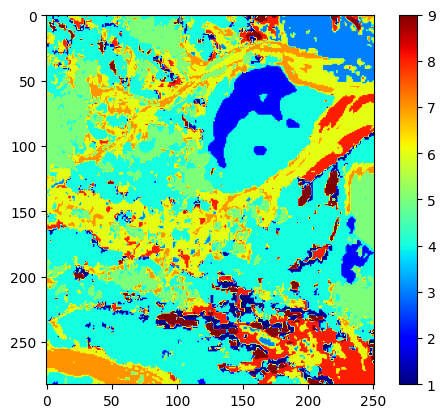

(283, 251)


In [ ]:
# Plot the predicted labels using a jet colormap
plt.imshow(predicted_map, cmap='jet')
plt.colorbar()
plt.show()
print(predicted_map.shape)

**Perfoemance metrics**

In [ ]:
# Get predictions from your model
predictions = vgg16_model.predict(test_x)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_y, predicted_labels)

# Compute precision, recall, and F1-score
precision = precision_score(test_y, predicted_labels, average='weighted')
recall = recall_score(test_y, predicted_labels, average='weighted')
f1 = f1_score(test_y, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

27/27 [==============================] - 0s 3ms/step
Precision: 0.9976765179167157
Recall: 0.9976608187134502
F1-score: 0.99754676627971


In [ ]:
yTestPredicted = vgg16_model.predict(test_x)
y_score = yTestPredicted[:, 1:yTestPredicted.shape[1]]

27/27 [==============================] - 0s 3ms/step


**ROC curve**

In [ ]:
# Computing ROC parameters for each class
n_classes = 9
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
test_y = label_binarize(test_y, classes=list(range(1, n_classes+1)))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Computing micro-average ROC parameters
fpr['micro'], tpr['micro'], _ = roc_curve(test_y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Computing macro-average ROC parameters
# First aggregating all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

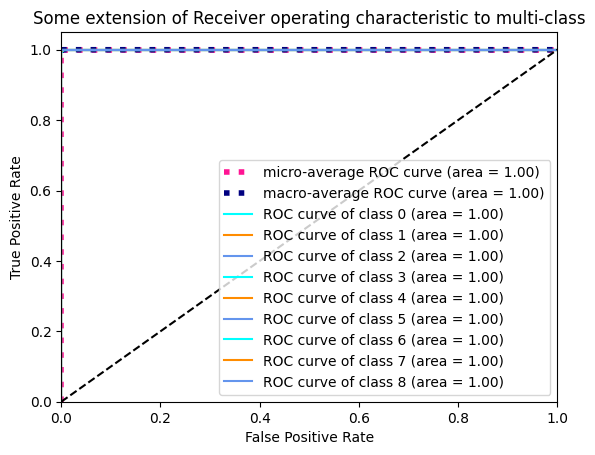

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()